<a href="https://colab.research.google.com/github/swilsonmfc/linear/blob/main/Camping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Camping

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQjgxE2QpU7Bxqf5qLn7oaegUij4VjXy3tmew&usqp=CAU" width="400"/>

# Setup

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.formula as smf
from statsmodels.discrete.count_model import ZeroInflatedPoisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP

# Data

In [133]:
camping_df = pd.read_csv('https://raw.githubusercontent.com/swilsonmfc/linear/main/camping.csv')

In [134]:
camping_df

,LIVE_BAIT,CAMPER,PERSONS,CHILDREN,FISH_COUNT
0,0,0,1,0,0
1,1,1,1,0,0
2,1,0,1,0,0
3,1,1,2,1,0
4,1,0,1,0,1
...,...,...,...,...,...
245,1,1,2,0,0
246,1,1,4,3,0
247,1,1,2,1,0
248,1,1,3,2,0


# Modeling Task
* Predict the count of fish caught for a camping party

# EDA

## Fish Count
* We want to predict the number of fish
* Poisson distribution is designed for counts
* Lot's of 0 fish caught
* One party caught over 140 fish (blast fishing?  Error?)

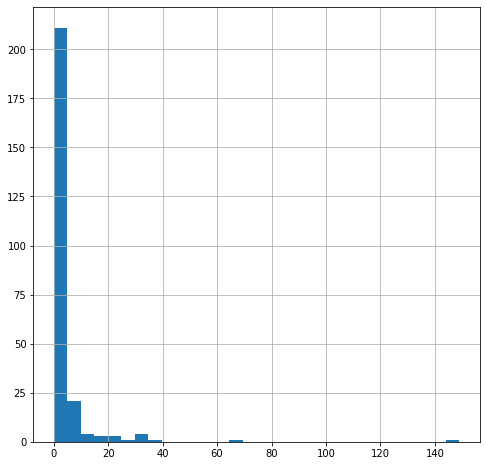

In [135]:
camping_df.FISH_COUNT.hist(bins=30, figsize=(8, 8))

In [136]:
no_fish = len(camping_df[camping_df.FISH_COUNT == 0])
fish    = len(camping_df) - no_fish
print(f'There were {len(camping_df)} records')
print(f'There were {fish} trips with fish caught')
print(f'There were {no_fish} trips with no fish')

There were 250 records
There were 108 trips with fish caught
There were 142 trips with no fish


## Live Bait
* Typical results are similar
* Many more outliers with live bair

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


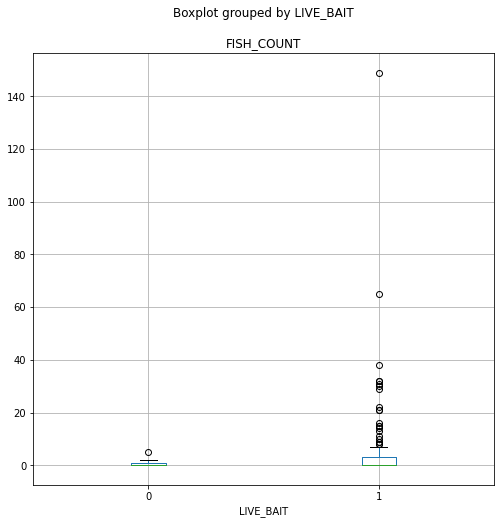

In [137]:
camping_df.boxplot('FISH_COUNT', by='LIVE_BAIT', figsize=(8, 8));

## Campers
* Having a camper appears to be related with more fish

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


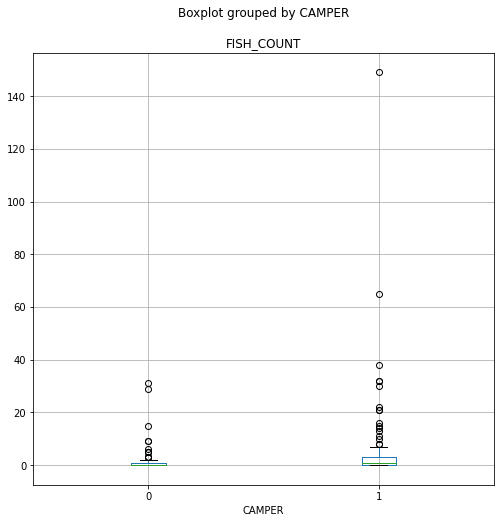

In [138]:
camping_df.boxplot('FISH_COUNT', by='CAMPER', figsize=(8, 8));

## Persons & Fish
* Appears to be positive related

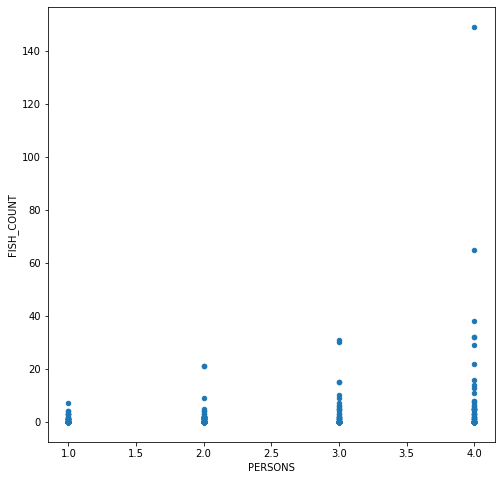

In [139]:
camping_df.plot.scatter(x='PERSONS', y='FISH_COUNT', figsize=(8, 8));

## Children & Fish
* Seems to be negatively related

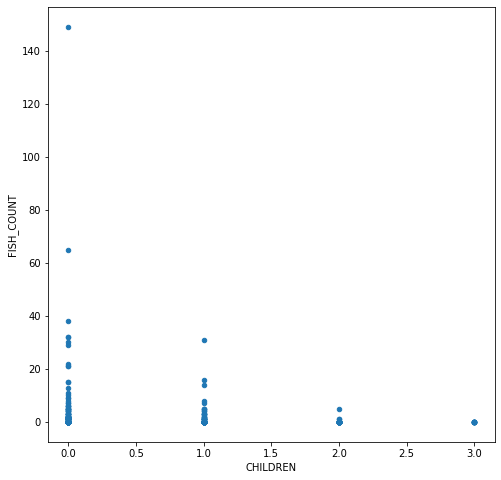

In [140]:
camping_df.plot.scatter(x='CHILDREN', y='FISH_COUNT', figsize=(8, 8));

# Train & Test

In [141]:
X = camping_df.copy()
y = X.FISH_COUNT
X = X.drop(columns=['FISH_COUNT'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=599) 

# Results

In [142]:
results_df = pd.DataFrame(columns=['MAE', 'RMSE', 'AIC'])

# Gaussian
* Without looking one might try OLS on this dataset

## Model

In [143]:
gm = sm.GLM(endog=y_train, exog=X_train)
gm_fit = gm.fit()
pred = gm_fit.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred) ** 0.5
results_df.loc['Gaussian'] = [mae, rmse, gm_fit.aic]
print(f'Mean Absolute Error    {mae:.2f}')
print(f'Root Mean Square Error {rmse:.2f}')

Mean Absolute Error    5.05
Root Mean Square Error 17.95


## Summary

In [144]:
print(gm_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             FISH_COUNT   No. Observations:                  187
Model:                            GLM   Df Residuals:                      183
Model Family:                Gaussian   Df Model:                            3
Link Function:               identity   Scale:                          46.671
Method:                          IRLS   Log-Likelihood:                -622.65
Date:                Thu, 18 Feb 2021   Deviance:                       8540.9
Time:                        14:43:52   Pearson chi2:                 8.54e+03
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
LIVE_BAIT     -1.3550      1.103     -1.228      0.2

## Residuals
* High leverage outlier in the data

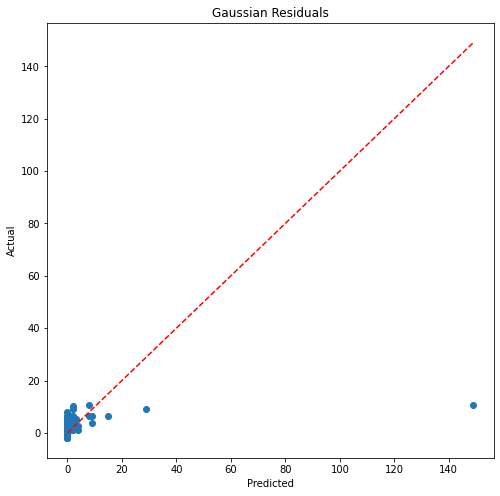

In [145]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(y_test, pred)
line = np.linspace(0, max(y_test) ,50)
plt.plot(line, line, '--', color='red') 
plt.title('Gaussian Residuals')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

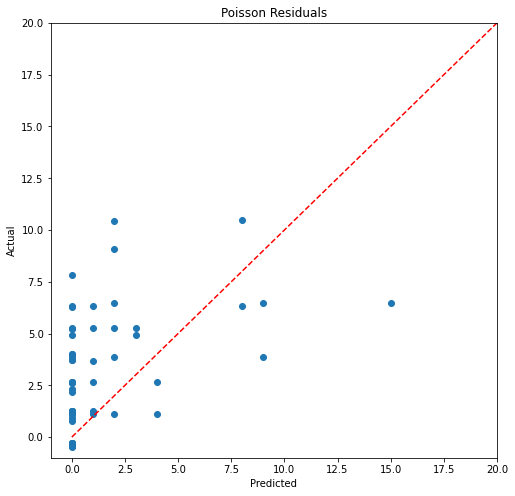

In [146]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(y_test, pred)
plt.plot(line, line, '--', color='red') 
plt.xlim(-1, 20)
plt.ylim(-1, 20)
plt.title('Poisson Residuals')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Outlier

In [147]:
X_test_out = X_test.copy()
X_test_out['Actual'] = y_test
X_test_out = X_test_out[X_test_out.Actual < 40]
y_test_out = X_test_out['Actual']
X_test_out = X_test_out.drop(columns=['Actual'])
pred = gm_fit.predict(X_test_out)
mae  = mean_absolute_error(y_test_out, pred)
rmse = mean_squared_error(y_test_out, pred) ** 0.5
results_df.loc['Outlier - Gaussian'] = [mae, rmse, gm_fit.aic]
print(f'Mean Absolute Error    {mae:.2f}')
print(f'Root Mean Square Error {rmse:.2f}')

Mean Absolute Error    2.90
Root Mean Square Error 4.21


# Poisson
* The typical parameteric model for count data
* Fish caught is a count
* Poisson makes an assumption that the mean == variance

![](https://miro.medium.com/max/524/1*nPldr72r5lcw5EQ9ijzO7w.png)


## Model

In [148]:
pm = sm.Poisson(endog=y_train, exog=X_train)
pm_fit = pm.fit()
pred = pm_fit.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred) ** 0.5
results_df.loc['Poisson'] = [mae, rmse, pm_fit.aic]
print(f'Mean Absolute Error    {mae:.2f}')
print(f'Root Mean Square Error {rmse:.2f}')

Optimization terminated successfully.
         Current function value: 3.261050
         Iterations 13
Mean Absolute Error    4.58
Root Mean Square Error 17.31


## Mean & Variance
* Poisson distributions assume mean == variance
* Here our training data has more variance

In [149]:
print(f'Mean         {y_train.mean():.2f}')
print(f'Standard Dev {y_train.std():.2f}')

Mean         3.02
Standard Dev 7.72


## Summary

In [150]:
print(pm_fit.summary())

                          Poisson Regression Results                          
Dep. Variable:             FISH_COUNT   No. Observations:                  187
Model:                        Poisson   Df Residuals:                      183
Method:                           MLE   Df Model:                            3
Date:                Thu, 18 Feb 2021   Pseudo R-squ.:                  0.3820
Time:                        14:43:53   Log-Likelihood:                -609.82
converged:                       True   LL-Null:                       -986.70
Covariance Type:            nonrobust   LLR p-value:                4.595e-163
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
LIVE_BAIT     -0.1813      0.096     -1.893      0.058      -0.369       0.006
CAMPER         0.4423      0.089      4.947      0.000       0.267       0.618
PERSONS        0.6144      0.030     20.598      0.0

## Dispersion
* The Pearson statistic provides an estimate of dispersion
* Divide Pearson chi2 by Df Residuals to find a dispersion ratio
  * Approximately 1 for a good fitting poisson
  * Ratio less than 1 implies under dispersed
  * Ratio more than 1 implies over dispersed
* Under dispersed may need a zero-inflated model
* Over dispersed may need Negative Binomial regression model
* Note:  You can find Pearson Chi2 through the GLM interface in statsmodels (using Poisson as the family)

In [151]:
data = X_train.copy()
data['FISH_COUNT'] = y_train
dispersion = smf.api.glm('FISH_COUNT ~ 0 + LIVE_BAIT + CAMPER + PERSONS + CHILDREN',
             data=data, family=sm.families.Poisson())
dispersion_fit = dispersion.fit()
print(dispersion_fit.summary())
print(f'Dispersion = {dispersion_fit.pearson_chi2 / dispersion_fit.df_resid:.2f}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:             FISH_COUNT   No. Observations:                  187
Model:                            GLM   Df Residuals:                      183
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -609.82
Date:                Thu, 18 Feb 2021   Deviance:                       955.36
Time:                        14:43:53   Pearson chi2:                 1.53e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
LIVE_BAIT     -0.1813      0.096     -1.893      0.0

## Residuals
* Note:  Poisson is predicting the mean which is typically not a whole number


In [152]:
pd.DataFrame({'Actual': y_test, 'Predicted': pred})

,Actual,Predicted
73,0,0.473759
109,1,3.643364
142,0,6.316228
59,4,2.399775
143,0,1.970985
...,...,...
168,0,0.473759
36,1,1.066262
158,0,2.399775
23,3,4.435982


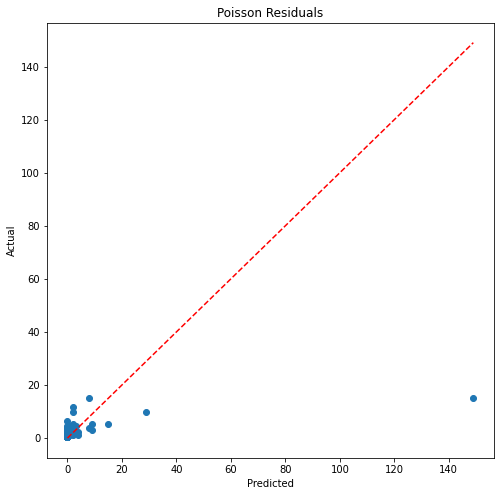

In [153]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(y_test, pred)
line = np.linspace(0, max(y_test) ,50)
plt.plot(line, line, '--', color='red') 
plt.title('Poisson Residuals')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

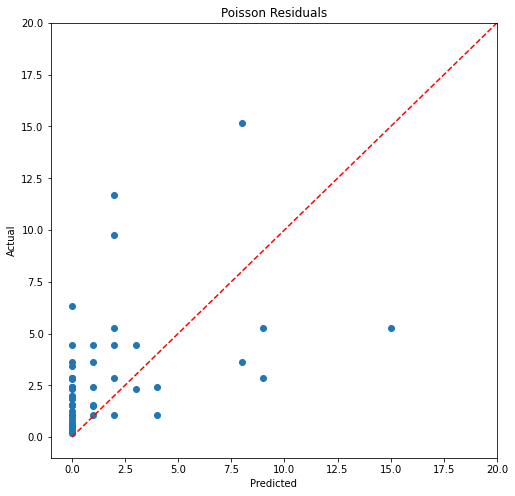

In [154]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(y_test, pred)
plt.plot(line, line, '--', color='red') 
plt.xlim(-1, 20)
plt.ylim(-1, 20)
plt.title('Poisson Residuals')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Outlier

In [155]:
X_test_out = X_test.copy()
X_test_out['Actual'] = y_test
X_test_out = X_test_out[X_test_out.Actual < 40]
y_test_out = X_test_out['Actual']
X_test_out = X_test_out.drop(columns=['Actual'])
pred = pm_fit.predict(X_test_out)
mae  = mean_absolute_error(y_test_out, pred)
rmse = mean_squared_error(y_test_out, pred) ** 0.5
results_df.loc['Outlier - Poisson'] = [mae, rmse, pm_fit.aic]
print(f'Mean Absolute Error    {mae:.2f}')
print(f'Root Mean Square Error {rmse:.2f}')

Mean Absolute Error    2.50
Root Mean Square Error 3.95


# Zero Inflated Poisson
* There an excess of zeros in the target
* Combine a logit to decide zero or poisson distribution

## Model

In [156]:
zipm = sm.ZeroInflatedPoisson(endog=y_train, exog=X_train, exog_infl=X_train)
zipm_fit = zipm.fit()
pred = zipm_fit.predict(X_test, exog_infl=X_test)
mae  = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred) ** 0.5
results_df.loc['Zero Inflated Poisson'] = [mae, rmse, zipm_fit.aic]
print(f'Mean Absolute Error    {mae:.2f}')
print(f'Root Mean Square Error {rmse:.2f}')

Optimization terminated successfully.
         Current function value: 2.578763
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
Mean Absolute Error    4.28
Root Mean Square Error 17.28


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## Summary

In [157]:
print(zipm_fit.summary())

                     ZeroInflatedPoisson Regression Results                    
Dep. Variable:              FISH_COUNT   No. Observations:                  187
Model:             ZeroInflatedPoisson   Df Residuals:                      183
Method:                            MLE   Df Model:                            3
Date:                 Thu, 18 Feb 2021   Pseudo R-squ.:                  0.2802
Time:                         14:43:54   Log-Likelihood:                -482.23
converged:                        True   LL-Null:                       -669.96
Covariance Type:             nonrobust   LLR p-value:                 4.584e-81
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_LIVE_BAIT     0.8641      0.416      2.079      0.038       0.049       1.679
inflate_CAMPER       -0.5715      0.355     -1.608      0.108      -1.268       0.125
inflate_PERSONS 

## Residuals

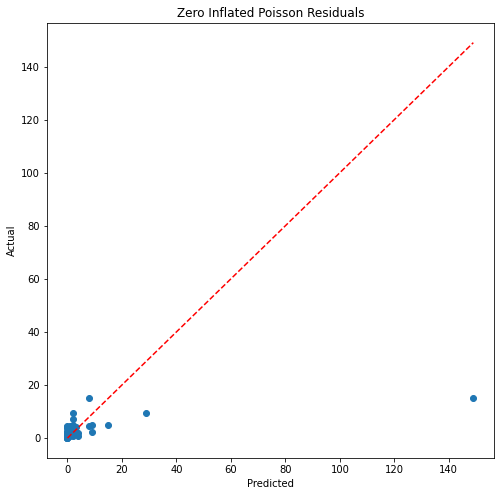

In [158]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(y_test, pred)
line = np.linspace(0, max(y_test) ,50)
plt.plot(line, line, '--', color='red') 
plt.title('Zero Inflated Poisson Residuals')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

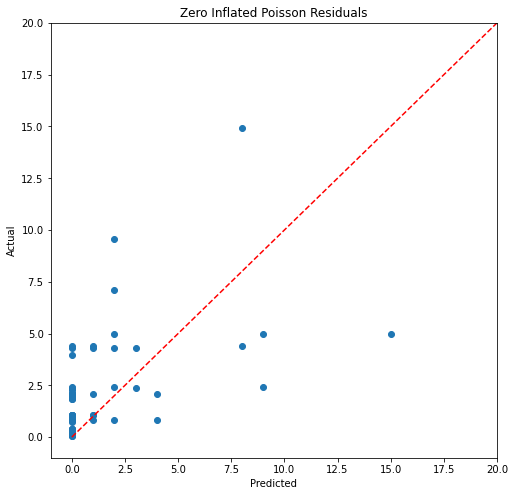

In [159]:
fig = plt.figure(figsize=(8, 8))
plt.scatter(y_test, pred)
plt.plot(line, line, '--', color='red') 
plt.xlim(-1, 20)
plt.ylim(-1, 20)
plt.title('Zero Inflated Poisson Residuals')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Outlier

In [160]:
X_test_out = X_test.copy()
X_test_out['Actual'] = y_test
X_test_out = X_test_out[X_test_out.Actual < 40]
y_test_out = X_test_out['Actual']
X_test_out = X_test_out.drop(columns=['Actual'])
pred = zipm_fit.predict(X_test_out, exog_infl=X_test_out)
mae  = mean_absolute_error(y_test_out, pred)
rmse = mean_squared_error(y_test_out, pred) ** 0.5
results_df.loc['Outlier - Zero Inflated Poisson'] = [mae, rmse, zipm_fit.aic]
print(f'Mean Absolute Error    {mae:.2f}')
print(f'Root Mean Square Error {rmse:.2f}')

Mean Absolute Error    2.18
Root Mean Square Error 3.70


# Negative Binomial
* Is our data over representing zero or just over dispersed?
* The negative binomial regression model works well on over-dispersed data, it keeps variance proportional to mean
* P parameter controls the variance:
  * nb2: Variance equal to 𝜇+𝛼𝜇2 (most common)
  * nb1: Variance equal to 𝜇+𝛼𝜇
  * geometric: Variance equal to 𝜇+𝜇2

## Model

In [161]:
nb = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial())
nb_fit = nb.fit()
pred = nb_fit.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred) ** 0.5
results_df.loc['Negative Binomial'] = [mae, rmse, nb_fit.aic]
print(f'Mean Absolute Error    {mae:.2f}')
print(f'Root Mean Square Error {rmse:.2f}')

Mean Absolute Error    4.53
Root Mean Square Error 17.48


## Summary

In [162]:
print(nb_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             FISH_COUNT   No. Observations:                  187
Model:                            GLM   Df Residuals:                      183
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -335.59
Date:                Thu, 18 Feb 2021   Deviance:                       265.22
Time:                        14:43:54   Pearson chi2:                     559.
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
LIVE_BAIT     -0.4216      0.207     -2.034      0.0

## Outlier

In [163]:
X_test_out = X_test.copy()
X_test_out['Actual'] = y_test
X_test_out = X_test_out[X_test_out.Actual < 40]
y_test_out = X_test_out['Actual']
X_test_out = X_test_out.drop(columns=['Actual'])
pred = nb_fit.predict(X_test_out)
mae  = mean_absolute_error(y_test_out, pred)
rmse = mean_squared_error(y_test_out, pred) ** 0.5
results_df.loc['Outlier - Neg Binomial'] = [mae, rmse, nb_fit.aic]
print(f'Mean Absolute Error    {mae:.2f}')
print(f'Root Mean Square Error {rmse:.2f}')

Mean Absolute Error    2.43
Root Mean Square Error 4.08


# Zero Inflated Negative Binomial
* What if we have many zeros and over-dispersed count data?
* Negative Binomial often fits better than a standard Poisson model when over dispersed
* Here we combine an overdispersed model with zero inflation


## Model

In [164]:
zinb = sm.ZeroInflatedNegativeBinomialP(endog=y_train, exog=X_train, exog_infl=X_train, p=2)
zinb_fit = zinb.fit()
pred = zinb_fit.predict(X_test, exog_infl=X_test)
mae  = mean_absolute_error(y_test, pred)
rmse = mean_squared_error(y_test, pred) ** 0.5
results_df.loc['Zero Inflated Neg Bimomial'] = [mae, rmse, zinb_fit.aic]
print(f'Mean Absolute Error    {mae:.2f}')
print(f'Root Mean Square Error {rmse:.2f}')

         Current function value: 1.662922
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40
Mean Absolute Error    4.42
Root Mean Square Error 17.56


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


## Summary

In [165]:
print(zinb_fit.summary())

                     ZeroInflatedNegativeBinomialP Regression Results                    
Dep. Variable:                        FISH_COUNT   No. Observations:                  187
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      183
Method:                                      MLE   Df Model:                            3
Date:                           Thu, 18 Feb 2021   Pseudo R-squ.:                  0.1219
Time:                                   14:43:55   Log-Likelihood:                -310.97
converged:                                 False   LL-Null:                       -354.12
Covariance Type:                       nonrobust   LLR p-value:                 1.361e-18
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
inflate_LIVE_BAIT    -0.5349      1.314     -0.407      0.684      -3.110       2.040
inflate_CAMPER       -

## Outlier

In [166]:
X_test_out = X_test.copy()
X_test_out['Actual'] = y_test
X_test_out = X_test_out[X_test_out.Actual < 40]
y_test_out = X_test_out['Actual']
X_test_out = X_test_out.drop(columns=['Actual'])
pred = zinb_fit.predict(X_test_out, exog_infl=X_test_out)
mae  = mean_absolute_error(y_test_out, pred)
rmse = mean_squared_error(y_test_out, pred) ** 0.5
results_df.loc['Outlier - Zero Inflated Neg Binomial'] = [mae, rmse, zinb_fit.aic]
print(f'Mean Absolute Error    {mae:.2f}')
print(f'Root Mean Square Error {rmse:.2f}')

Mean Absolute Error    2.30
Root Mean Square Error 3.98


# Results

In [167]:
results_df.sort_values('MAE')

,MAE,RMSE,AIC
Outlier - Zero Inflated Poisson,2.182598,3.702996,972.457366
Outlier - Zero Inflated Neg Binomial,2.302755,3.976652,629.932845
Outlier - Neg Binomial,2.428846,4.075643,679.173919
Outlier - Poisson,2.499744,3.946692,1227.632797
Outlier - Gaussian,2.901858,4.214255,1253.304883
Zero Inflated Poisson,4.275773,17.283931,972.457366
Zero Inflated Neg Bimomial,4.421608,17.556940,629.932845
Negative Binomial,4.532352,17.476196,679.173919
Poisson,4.584550,17.311132,1227.632797
Gaussian,5.054519,17.945584,1253.304883


## AIC
* AIC provides an estimate of the quality of each model relative to other models on the same data
* AIC provides a means for model selection
* AIC = 2k - 2 ln(L)
  * k : number of parameters 
  * L : max value of the likelihood for the model
* Log-Likelihood (Larger is Better) can also be used to compare fit

## Selection
* Based on lowest MAE - Zero Inflated Poisson
* Based on AIC - Zero Inflated Negative Binomial

# Notes on Count Models
* We're approaching a count problem, Poisson is a good place to start
* Poisson models assume that the mean == variance
  * The Negative Binomial Distribution doesn't make that assumption
  * Under or over dispersed data - Use the Generalized Poisson Model
  * https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.GeneralizedPoisson.html
* With excess zeros in the count, a Zero Inflated Poisson can help
  * Think Logistic + Poisson
  * https://stats.stackexchange.com/questions/112292/are-my-data-zero-inflated
  * https://statisticalhorizons.com/zero-inflated-models
* Be wary of trying every distribution
  * Explainability through coefficients is often an advantage of the GLM
  * Improper distributions fit to the data violate assumptions